# Moderate collection preprocessing

# Summary of what works

## Dataset

Dataset class called 'ModerateDataset' created

- Allows for all Moderate collection images, colour and depth, to be read into Pytorch Tensors
- Returns these two tensors as col_img and depth_img

## Dataloader

Dataloader created that allows for the batching and shuffling of Moderate collection images
- Allows a given batch size to be created
- Can be used to create training, validation and testing datasets based on instancing the ModerateDataset class (yet to be implemented)

# To be done

## Standardisation

- Method is avaliable in the lecture 8 notebook

## CNN model

- Code avaliable in both the lecture 8 notebook and via nick and kari's github pages
- CNN layers to be decided
- Training with dataloader to be done (without callbacks first and then with)

## Depth conversion

- Formula known but not implemented in code, this will be worked on in later weeks as it is not as time sensitive as other matters above


## Required imports

In [1]:
import torch
import torchvision
import pandas as pd
import numpy as np
from PIL import Image
from Functions import import_raw_colour_image, import_raw_depth_image, show_depth_image, show_img
import os
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

plt.ion()   # interactive mode

# Reading in data descriptions from csv and saving information

In [2]:
import csv
with open('data_descriptions.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    count = 0
    for row in spamreader:
        if count == 0:
            folder_names = row
        else:
            num_files = row
        count = 1

Converting the numbers read in from the csv to integers

In [3]:
for i in range(0,len(num_files)):
    num_files[i] = int(num_files[i])
# folder_names

Creating the filenames for each image e.g. 'colour_00020.raw', 'depth_03021.raw' for use in appending to filepaths

In [5]:
list_of_numbers = ["{0:05}".format(i) for i in range(1, sum(num_files)+1)]
colour_filenames = []
depth_filenames = []
for num in list_of_numbers:
    colour_filenames.append(f"colour_{num}.raw")
    depth_filenames.append(f"depth_{num}.raw")

# Moderate dataset

Creating a dataset class called 'ModerateDataset' that will allow the reading of images from Moderate Collection and their conversion to Pytorch Tensors.

In [6]:
class ModerateDataset(Dataset):

    def __init__(self, col_dir='', depth_dir='', transform=transforms.ToTensor(),trans_on=False):
        self.path_names = {}
        for folder in folder_names:
            self.path_names[f"{folder}"] = {}
        for folder in folder_names:
            self.path_names[f'{folder}']['colour'] = {}
            self.path_names[f'{folder}']['depth'] = {}
        for i in range(1, num_files[0]):
            self.path_names['Sunny']['colour'][f"{i}"] = {}
            self.path_names['Sunny']['depth'][f"{i}"] = {}
        print("*************MAKE SURE THE PATH FILE IN THE FOR LOOP IS THE BASE IMAGE DIRECTORY ON YOUR COMPUTER**************")
        count = 0
        for folder in folder_names:
            for i in range(0, num_files[folder_names.index(folder)]):
                self.path_names[f'{folder}']['colour'][f'{i+1}'] = Path(f"C:/Users/Ben/OneDrive - Bournemouth University/Computer Vision/Moderate collection/{folder}/colour/{colour_filenames[count+i]}")
                self.path_names[f'{folder}']['depth'][f'{i+1}'] = Path(f"C:/Users/Ben/OneDrive - Bournemouth University/Computer Vision/Moderate collection/{folder}/depth/{depth_filenames[count+i]}")
            count = count + num_files[folder_names.index(folder)]
        
        self.transform = transform
        self.col_dir = col_dir
        self.depth_dir = depth_dir
        self.trans_on = trans_on

    def __getitem__(self,idx):
        if idx == 0:
            
            self.col_dir = self.path_names[f'{folder_names[0]}']['colour'][f'{idx+1}']
            self.depth_dir = self.path_names[f'{folder_names[0]}']['depth'][f'{idx+1}']
        
        if (idx>0 and idx <= num_files[0]):  ## 1-500

            self.col_dir = self.path_names[f'{folder_names[0]}']['colour'][f'{idx}']
            self.depth_dir = self.path_names[f'{folder_names[0]}']['depth'][f'{idx}']

        elif (idx > num_files[0] and idx < (sum(num_files[:2])+1)): ## 501 - 1500

            self.col_dir = self.path_names[f'{folder_names[1]}']['colour'][f'{idx-num_files[0]}']
            self.depth_dir = self.path_names[f'{folder_names[1]}']['depth'][f'{idx-num_files[0]}']

        elif (idx > sum(num_files[:2]) and idx < (sum(num_files[:3])+1) ): ## 1501 - 2600

            self.col_dir = self.path_names[f'{folder_names[2]}']['colour'][f'{idx-sum(num_files[:2])}'] # -1500
            self.depth_dir = self.path_names[f'{folder_names[2]}']['depth'][f'{idx-sum(num_files[:2])}']

        elif (idx > sum(num_files[:3]) and idx < (sum(num_files[:4])+1) ): ## 2601 - 5600

            self.col_dir = self.path_names[f'{folder_names[3]}']['colour'][f'{idx-sum(num_files[:3])}'] #-2600
            self.depth_dir = self.path_names[f'{folder_names[3]}']['depth'][f'{idx-sum(num_files[:3])}']
            
        elif (idx > sum(num_files[:4]) and idx < (sum(num_files[:5])+1) ): ## 5601 - 7857

            self.col_dir = self.path_names[f'{folder_names[4]}']['colour'][f'{idx-sum(num_files[:4])}'] # -5600
            self.depth_dir = self.path_names[f'{folder_names[4]}']['depth'][f'{idx-sum(num_files[:4])}']

        elif (idx > sum(num_files)):
            raise NameError('Index outside of range')

        col_img = import_raw_colour_image(self.col_dir)
        depth_img = import_raw_depth_image(self.depth_dir)
        if self.trans_on == True:
            col_img = torch.from_numpy(np.flip(col_img,axis=0).copy()) # apply any transforms
            depth_img = torch.from_numpy(np.flip(depth_img,axis=0).copy()) # apply any transforms

        return col_img, depth_img
    
    def __len__(self):
        return sum(num_files)



## Example instancing of the 'ModerateDataset' class.
- trans_on is a Bool toggle allowing for images to be returned as numpy arrays (false) or Pytorch tensors (True).
- The show_img and show_depth_img functions only work with numpy arrays.
## ***BEWARE***
- trans_on is False by default so numpy arrays are returned

In [7]:
sData = ModerateDataset(trans_on=True)

*************MAKE SURE THE PATH FILE IN THE FOR LOOP IS THE BASE IMAGE DIRECTORY ON YOUR COMPUTER**************


In [8]:
example = sData[0] # 1 here is the index of the image in the dataset (1-500:Sunny, 501-1500:Snowy etc... see conditions.txt)

In [9]:
example_images = sData[0]

In [10]:
## Show funs will not work with pytorch tensors!!!
show_img(example[0], figsize=(8,8))
show_depth_image(example[1])

ValueError: negative step not yet supported

# Creating a dataloader
## Beware 2.0
- From here onwards, Pytorch tensors are required so change trans_on to True

# TESTING

# END OF TESTING

In [11]:
img_dataloader = DataLoader(sData, batch_size=4, shuffle=True, num_workers=0)
x,y = next(iter(img_dataloader))


In [12]:
x,y = next(iter(img_dataloader))

In [13]:
x.shape

torch.Size([4, 720, 1280, 3])

In [14]:
y.shape

torch.Size([4, 720, 1280])

## Attempt to create image viewing functions for the tensor objects
- From here on, the code is not operational and should be omitted in any implementations

In [15]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(0,1,2)), interpolation='nearest')

In [16]:
idx = [i for i in range(x[0].size(0)-1, -1, -1)]
idx = torch.LongTensor(idx)
inverted_tensor = x[0].index_select(0, idx)

In [17]:
inverted_tensor.shape

torch.Size([720, 1280, 3])

In [18]:
#torch.flip(inverted_tensor,[0,1])

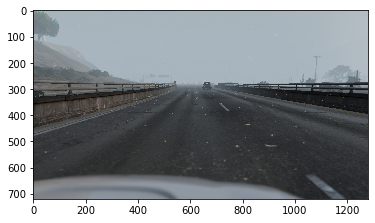

In [19]:
show(torch.flip(inverted_tensor,[1,2])) ## correct colours but horizontally flipped

In [20]:
idx = [i for i in range(y[0].size(0)-1, -1, -1)]
idx = torch.LongTensor(idx)
depth_inv = y[0].index_select(0, idx)

In [21]:
depth_inv.shape

torch.Size([720, 1280])

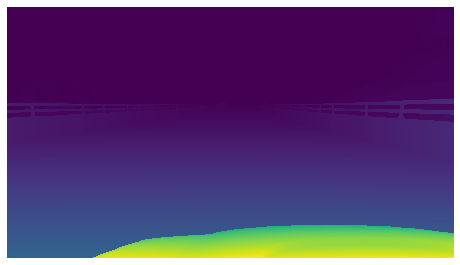

In [22]:
show_depth_image(depth_inv)

In [23]:
inv_idx = torch.arange(x[0].size(0)-1, -1, -1).long()
# or equivalently torch.range(tensor.size(0)-1, 0, -1).long()
inv_tensor = x[0].index_select(0, inv_idx)
# or equivalently
inv_tensor = x[0][inv_idx]

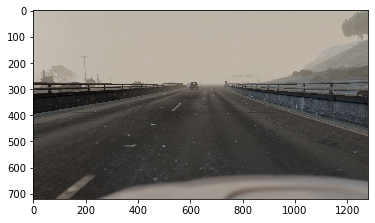

In [24]:
show(inv_tensor)

In [25]:
from tqdm.notebook import trange, tqdm

In [55]:
def get_stats(dataloader):
    count, rolling_sum, rolling_sum_squared = torch.zeros(1), torch.zeros(3), torch.zeros(3)
    
    for image,_ in tqdm(dataloader):
        print(image.shape)
        count += image.shape[0]*image.shape[1]*image.shape[2]
        rolling_sum += image.sum(dim=(0,1,2))
        rolling_sum_squared += (image*image).sum(dim=(0,1,2))
        μ = rolling_sum / count
        σ = (rolling_sum_squared / count - μ**2).sqrt()
        # print(σ[0]) #= torch.sqrt(σ)
        print(f"count = {count} \t rolling sum = {rolling_sum} \t rolling square = {rolling_sum_squared} \t mu = {μ} \t σ = {σ}")
        break
    #μ = rolling_sum / count
    #σ = (rolling_sum_squared / count - μ**2).sqrt()
    return μ, σ, count, rolling_sum, rolling_sum_squared

In [56]:
mu, sig, cnt, roll_sum, roll_sqr =get_stats(img_dataloader)

torch.Size([4, 720, 1280, 3])
count = tensor([3686400.]) 	 rolling sum = tensor([4.0920e+08, 4.1495e+08, 4.0909e+08]) 	 rolling square = tensor([4.0458e+08, 4.0962e+08, 4.1229e+08]) 	 mu = tensor([111.0030, 112.5615, 110.9740]) 	 σ = tensor([nan, nan, nan])


In [44]:
roll_sqr/cnt

tensor([115.3813, 113.8907, 108.2895])

In [45]:
mu**2

tensor([6397.6416, 6027.7466, 5419.5723])

# marcin's dataset testing my get data vs his

In [47]:
from torchvision import datasets, transforms
from tempfile import TemporaryDirectory
d = TemporaryDirectory(prefix='STL10')
d.name = 'C:\\Users\\Ben\\AppData\\Local\\Temp\\STL10_vt_0_vy'

In [48]:
tr_ds = datasets.STL10(root=d.name, split='train', download=False, transform=transforms.ToTensor())
tr_ds

Dataset STL10
    Number of datapoints: 5000
    Root location: C:\Users\Ben\AppData\Local\Temp\STL10_vt_0_vy
    Split: train
    StandardTransform
Transform: ToTensor()

In [49]:
ds = datasets.STL10(root=d.name, split='test', download=False)
ds[0]

(<PIL.Image.Image image mode=RGB size=96x96 at 0x252CF436CA0>, 6)

In [50]:
tr_dl  = DataLoader(tr_ds,  batch_size=4, shuffle=True,  num_workers=2)

In [51]:
xb, yb = next(iter(tr_dl))
xb.shape

torch.Size([4, 3, 96, 96])

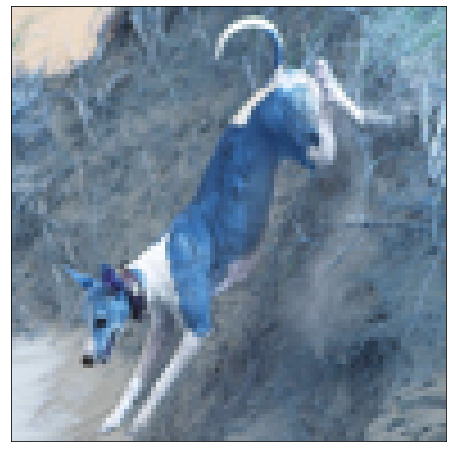

In [52]:
show_img(xb[0].numpy().transpose(1,2,0));

In [59]:
def marcin_get_stats(dl):
    cnt, csum, csum_sq = torch.zeros(1), torch.zeros(3), torch.zeros(3)
    
    for xb,_ in tqdm(dl):
        print(xb.shape)
        cnt += xb.shape[0]*xb.shape[2]*xb.shape[3]
        print(f"xb.shape[0] = {xb.shape[0]} \t xb.shape[1] = {xb.shape[1]} \t xb.shape[2] = {xb.shape[2]} \t xb.shape[3] = {xb.shape[3]}")
        csum += xb.sum(dim=(0,2,3))
        print(f"\t  xb.sum(dim=(0,2,3)) = {xb.sum(dim=(0,2,3))}")
        csum_sq += (xb*xb).sum(dim=(0,2,3))
        μ = csum / cnt
        σ = (csum_sq / cnt - μ**2)
        # print(σ[0]) #= torch.sqrt(σ)
        # print(f"count = {cnt} \t rolling sum = {csum} \t rolling square = {csum_sq} \t mu = {μ} \t σ = {σ}")
        break
    μ = csum / cnt
    σ = (csum_sq / cnt - μ**2).sqrt()
    print(f"count = {cnt} \t rolling sum = {csum} \t rolling square = {csum_sq} \t mu = {μ} \t σ = {σ}")
    return μ, σ

stl10_stats = marcin_get_stats(tr_dl)
stl10_stats

torch.Size([4, 3, 96, 96])
xb.shape[0] = 4 	 xb.shape[1] = 3 	 xb.shape[2] = 96 	 xb.shape[3] = 96
	  xb.sum(dim=(0,2,3)) = tensor([17864.4180, 17776.3633, 18108.8809])
count = tensor([36864.]) 	 rolling sum = tensor([17864.4180, 17776.3633, 18108.8809]) 	 rolling square = tensor([10313.4590, 10386.2031, 10936.6982]) 	 mu = tensor([0.4846, 0.4822, 0.4912]) 	 σ = tensor([0.2120, 0.2218, 0.2353])


(tensor([0.4846, 0.4822, 0.4912]), tensor([0.2120, 0.2218, 0.2353]))

In [58]:
get_stats(tr_dl)

torch.Size([4, 3, 96, 96])


RuntimeError: The size of tensor a (3) must match the size of tensor b (96) at non-singleton dimension 0